# Cryptocurrency Price Prediction

### Import Dependencies

In [1]:
import datetime
import numpy as np
import pandas as pd
import dash
from dash import Input, Output, dcc, html
import dash_bootstrap_components as dbc
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
import pandas_datareader.data as web
from sklearn.metrics import mean_squared_error, accuracy_score
import xgboost as xgb

### Load Data
- Historical Closing Price data are from [yahoo finance](https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD&.tsrc=fin-srch)

In [2]:
# Get data
start = datetime.datetime(2014,9,15)
end = datetime.date.today()
nextday = end + datetime.timedelta(days=1)
raw_df = web.DataReader(
    ["BCH-USD","BNB-USD", "ETH-USD", "BTC-USD", "AVAX-USD", "SOL-USD", "DOGE-USD"], 
    "yahoo",
    start=start,
    end=end
    )
raw_df = raw_df.stack().reset_index()

### Explore the data 
 - Select a coin from the raw data frame (rawd_df)

In [3]:
coin_selected = "BCH-USD"

In [4]:
dff = raw_df[raw_df["Symbols"] == coin_selected]
dff = dff.set_index("Date")
dff.head()

Attributes,Symbols,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2017-11-09,BCH-USD,654.302979,654.302979,670.135986,619.257996,622.312012,7.103870e+08
2017-11-10,BCH-USD,1007.419983,1007.419983,1034.770020,651.775024,651.775024,5.195420e+09
2017-11-11,BCH-USD,1340.449951,1340.449951,1403.660034,910.721985,1001.640015,5.139770e+09
2017-11-12,BCH-USD,1388.859985,1388.859985,2477.649902,1215.579956,1346.969971,8.371320e+09
2017-11-13,BCH-USD,1353.989990,1353.989990,1501.160034,1043.000000,1381.819946,4.850570e+09


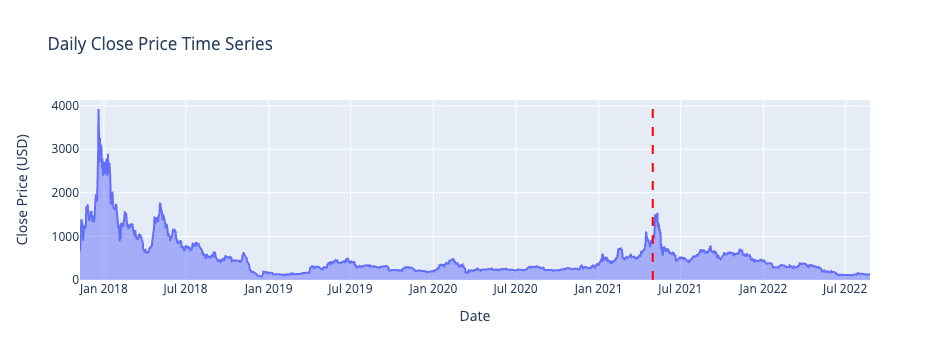

In [32]:
fig = px.area(dff, y="Close", 
        title="Daily Close Price Time Series", 
        labels={"Close": "Close Price (USD)"})
fig.add_vline(x=test_start_dates[coin_selected], line_width=2, line_dash="dash", line_color="red")

### Test Start Dates

In [6]:
test_start_dates = {
    "BCH-USD": "2021-05",
    "BTC-USD": "2021-06",
    "ETH-USD": "2021-06",
    "BNB-USD": "2021-12",
    "SOL-USD": "2021-12",
    "AVAX-USD": "2021-12",
    "DOGE-USD": "2021-09",
    "ADA-USD": "2021-09",
    "XRP-USD": "2021-09",
    "ETC-USD": "2021-09",
    "BTC-USD": "2021-09",
    "KYL-USD": "2021-11",
}

## Create Features 

In [7]:
def create_features(data, window_size):
    '''
    This function converts the "Close" price column into a features table
    using a given window size
    
    INPUTS:
    ------
    data: the row data from Yahoo Finance
    window_size:
    
    OUTPUT:
    ------
    df: a data frame with the "Close"
    '''
    df = data[["Close"]].copy()
    
    for i in range(1, window_size + 1):
        df[f"Close-{i}"] = df["Close"].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [8]:
window_size = 3
df = create_features(dff, window_size)
df.head()

Attributes,Close,Close-1,Close-2,Close-3
Date,,,,
2017-11-12,1388.859985,1340.449951,1007.419983,654.302979
2017-11-13,1353.989990,1388.859985,1340.449951,1007.419983
2017-11-14,1273.530029,1353.989990,1388.859985,1340.449951
2017-11-15,1212.400024,1273.530029,1353.989990,1388.859985
2017-11-16,900.776001,1212.400024,1273.530029,1353.989990


In [9]:
df.tail()

Attributes,Close,Close-1,Close-2,Close-3
Date,,,,
2022-08-21,119.310364,114.680069,114.595329,129.262726
2022-08-22,122.857780,119.310364,114.680069,114.595329
2022-08-23,133.494919,122.857780,119.310364,114.680069
2022-08-24,131.212296,133.494919,122.857780,119.310364
2022-08-25,130.928757,131.212296,133.494919,122.857780


## Training / Test Split

In [10]:
def tss(features_df, test_start_date):
    df = features_df.copy()
    n = test_start_date
    train = df.loc[:n]
    test = df.loc[n:]
    X_train = train.drop(columns="Close").values
    y_train = train[["Close"]].values
    X_test = test.drop(columns="Close").values
    y_test = test[["Close"]].values
    test_date_index = test.index

    
    return X_train, y_train, X_test, y_test, test_date_index 

In [11]:
test_date = test_start_dates[coin_selected]
X_train, y_train, X_test, y_test, test_date_index = tss(df,test_date)

In [12]:
for i in [X_train, y_train, X_test, y_test]:
    print(f"{i.shape}")

(1297, 3)
(1297, 1)
(482, 3)
(482, 1)


## Model Selection

Although, at the start of our prject we considered using the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) after some exploration, we chose to work with the [XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/index.html).
>
> **XGBoost** is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework

## Train Model

In [13]:
model = xgb.XGBRegressor(objective="reg:squarederror",
                         n_estimators=700,
                         learning_rate=0.1,
                         random_state=1,
                        )
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=1,
             reg_alpha=None, reg_lambda=None, ...)

### Fit Model and Predict on Test Set

In [14]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=700, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0,
             reg_lambda=1, ...)

In [15]:
y_pred = model.predict(X_test)

In [16]:
plot_df = pd.DataFrame(y_test, columns=["Close"])
plot_df["Prediction"] = y_pred
plot_df.index = test_date_index

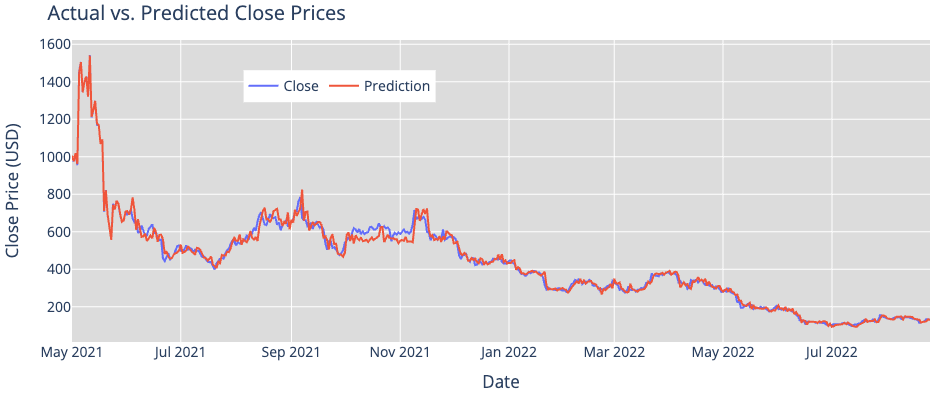

In [17]:
coin = coin_selected
fig = px.line(plot_df, 
        y=["Close", "Prediction"],
        title="Actual vs. Predicted Close Prices",
        labels={"value": "Close Price (USD)"},
        width=800, height=400
       )
fig.update_layout(
            font=dict(family="Open Sans", size=14),
            legend=dict(orientation="h",yanchor="top",y=0.9,xanchor="left", x=0.2),
            legend_title_text='',
            margin=dict(l=20, r=20, t=40, b=30),
            plot_bgcolor = '#DCDCDC',
            paper_bgcolor="#fff")

### Get features for next day prediction 

This is the last row from the Test set with the "Close" now being today's Close price, and we need to drop the oldest Close value from that last row.

In [26]:
X_today = y_test[-window_size::][::-1].reshape(1, window_size)    
y_nextday = model.predict(X_today)

In [27]:
# make the prediction
y_nextday = model.predict(X_today)
y_nextday[0]

129.09607

### Save Model

In [28]:
model.save_model(f"{coin_selected}.json")

### Use saved model for next prediction

In [29]:
new_model = xgb.XGBRegressor()
new_model.load_model(f"./{coin_selected}.json")
y_new_pred = new_model.predict(X_test)

In [30]:
y_new_pred[-1]

128.10399

### Calculate the root-mean-squared-error

In [25]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"The root mean squared error for {coin_selected}: {rmse:.2f}")

The root mean squared error for BCH-USD: 27.56
